Using 4k vocab is fairly small - should not be getting single characters

White space tokens are strange

We seem have >4k lines in the print out

Look at pretraining and how vocabulary is set up

In [3]:
import sys, os

In [71]:
sys.path.append(os.path.abspath(os.path.join('../..', 'aochildes')))

In [5]:
import re
from aochildes.dataset import AOChildesDataSet
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
from datasets import load_dataset
import time

from transformers import PreTrainedTokenizerFast

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [135]:
fast_tokenizer = PreTrainedTokenizerFast(tokenizer_file="baby_bert_tokenizer/tokenizer.json")

In [142]:
fast_tokenizer.encode('hello world ostentatious branjdkf.')

'hell o world o st ent at i ous br an j d k f.'

In [5]:
nltk.download('words')

ds = AOChildesDataSet()

transcripts = ds.load_transcripts()

[nltk_data] Downloading package words to /Users/user/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Looking for transcripts in /Users/user/Documents/aochildes/aochildes/original_transcripts
Utterances before dropping rows: 1,379,962
Utterances after  dropping rows: 1,180,889
Preparing AOCHILDES transcripts...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


In [73]:
# sys.path.append(os.path.abspath(os.path.join('..', 'data')))

vocab_freq = pd.read_csv('../data/AOChildes_word_frequency.csv')

# words_set = set(words.words())
vocab_set = set(vocab_freq['word'])

In [79]:
ds = load_dataset('super_glue','record')

Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/record/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

In [81]:
ds['train'].features

{'passage': Value(dtype='string', id=None),
 'query': Value(dtype='string', id=None),
 'entities': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'entity_spans': Sequence(feature={'text': Value(dtype='string', id=None), 'start': Value(dtype='int32', id=None), 'end': Value(dtype='int32', id=None)}, length=-1, id=None),
 'answers': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'idx': {'passage': Value(dtype='int32', id=None),
  'query': Value(dtype='int32', id=None)}}

In [78]:
def filter_example(example, vocab_set, contractions, additional_exclusions=True):
    """Filters a particular example in a dataset
    Args:
        example: an example in the dataset
        vocab_set: the set of aochildes vocabulary to filter by
        contractions: a list of contractions to be filtered out
        additional_exclusions: a flag to specify whether to exclude additional proper nouns
    """
    features = example.keys()
    if 'sentence' in features:
        sentence = example['sentence']
        
    else:
        t1 = list(features)[0]
        t2 = list(features)[1]
        sentence = example[t1]+" "+example[t2]
    
    new_sentence = sentence.split(' ')
            
    if additional_exclusions:
        new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
    new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
    new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
    
    for word in new_sentence:
        if word not in vocab_set:
            return False
    return True


def filter_dataset(dataset, 
    task_name, cache_dir, 
    use_auth_token=None, 
    aochildes_vocab_path="AOChildes_word_frequency.csv"
):
    """Filters GLUE datasets based on AOChildes vocabulary
    Args:
        task_name: name of GLUE dataset
        cache_dir: dir where data is cached
        use_auth_token: we will not need this mostly, but used by run_glue script
        aochildes_vocab_path: the path of AOChildes vocabulary
    """
    datasets = load_dataset(
        dataset,
        task_name,
        cache_dir=cache_dir,
        use_auth_token=True if use_auth_token else None,
    )
    vocab_freq = pd.read_csv(aochildes_vocab_path)
    vocab_set = set(vocab_freq['word'])
    contractions = set(['nt','s','re','t','d','ll'])
    for key in datasets.keys():
        datasets[key] = datasets[key].filter(lambda example: filter_example(example, vocab_set, contractions))
    return datasets

In [76]:
subsets = ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'mnli_mismatched', 'mnli_matched', 'qnli', 'rte', 'wnli', 'ax']
for ds in subsets:
    filter_glue_dataset(ds,'',None,'../data/AOChildes_word_frequency.csv')

Found cached dataset glue (/Users/user/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Found cached dataset glue (/Users/user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-397fe507617ceca8.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-8024a996e40bbe7b.arrow
Loading cached processed dataset at /Users/user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3386bb338994ea7a.arrow


Generating train split:   0%|          | 0/363846 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/40430 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/390965 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/364 [00:00<?, ?ba/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/391 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Generating validation split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/mnli_mismatched/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Generating validation split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/mnli_matched/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/105 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/rte/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Generating train split:   0%|          | 0/635 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/71 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/146 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/wnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Generating test split:   0%|          | 0/1104 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /Users/user/.cache/huggingface/datasets/glue/ax/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:

# subsets = ['cola']
graph_data = []
inclusivity_check = []
for subset in subsets:
    dataset = load_dataset('super_glue',subset)
    print(dataset)
    
    inclusivity_check_ds = []
    
    for segment in dataset.keys():
        print(segment)
        if subset == 'wsc' or subset == 'wsc.fixed':
            sentences = dataset[segment]['text']
        elif subset == 'record':
            sentences = dataset[segment]['passage']
        elif 'sentence' in dataset[segment].features:
            sentences = dataset[segment]['sentence']
        
        else:
            t1 = list(dataset[segment].features)[0]
            t2 = list(dataset[segment].features)[1]

In [ ]:
subsets = ['boolq', 'cb', 'copa', 'multirc', 'record', 'rte', 'wic', 'wsc', 'wsc.fixed', 'axb', 'axg']
for ds in subsets:
    filter_glue_dataset('super_glue','',None,'../data/AOChildes_word_frequency.csv')

In [18]:
ds = load_dataset('conll2003')

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /Users/user/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [23]:
ds['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None),
 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)}

## SQUAD, SWAG,CONLL CoRef, RACE

In [47]:
x = load_dataset('race','all')
x['train'][0]

Generating test split:   0%|          | 0/4934 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/87866 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4887 [00:00<?, ? examples/s]

Dataset race downloaded and prepared to /Users/user/.cache/huggingface/datasets/race/all/0.1.0/5839ff74a429622f5f20cca69c5fcf0e87ac6d5fd2777c42b948000684829f7b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'example_id': 'high19088.txt',
 'article': 'Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.\nGiven that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.\n"Surgery ," one replied.\nI was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .\nOne girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"\nAt that point, I was shocked. I am short, I can\'t

In [49]:
subsets = ['conll2003','squad','swag','race']

graph_data = []
inclusivity_check = []
for subset in subsets:
    if subset == 'swag':
        dataset = load_dataset(subset,"regular")
    elif subset == 'race':
        dataset = load_dataset(subset,"all")
    else:
        dataset = load_dataset(subset)
    print(dataset)
    
    inclusivity_check_ds = []
    
    for segment in dataset.keys():
        print(segment)
        if subset == "race":
            t1 = list(dataset[segment].features)[1]
            sentences = [' '.join(i) for i in dataset[segment][t1]]
        if subset == "squad":
            t1 = list(dataset[segment].features)[2]
            t2 = list(dataset[segment].features)[3]
            sentences = [' '.join(i) for i in zip(dataset[segment][t1], dataset[segment][t2])]
        if subset == "swag":
            t1 = list(dataset[segment].features)[2]
            t2 = list(dataset[segment].features)[6]
            t3 = list(dataset[segment].features)[7]
            t4 = list(dataset[segment].features)[8]
            t5 = list(dataset[segment].features)[9]
            sentences = [' '.join(i) for i in zip(dataset[segment][t1], dataset[segment][t2], dataset[segment][t3], dataset[segment][t4], dataset[segment][t5])]
        if subset == 'conll2003':
            t1 = list(dataset[segment].features)[1]
            sentences = [' '.join(i) for i in dataset[segment][t1]]
        
        denom = len(sentences)

        for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
            new_sentence = sentence.split(' ')
            #removing proper nouns helps with MRPC
            contractions = set(['nt','s','re','t','d','ll'])
            new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
            new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
            new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
            sentence_inclusion = []
            for word in new_sentence:
                if word not in vocab_set:
                    inclusive_word = 0
                else:
                    inclusive_word = 1
                sentence_inclusion.append(inclusive_word)
            inclusivity_check_ds.append(sentence_inclusion)
            inclusivity_check.append([subset, sentence_inclusion])
    
    complete_sentences = 0
    missing_1 = 0
    most_included = 0
    n_ex = len(inclusivity_check_ds)
    for sentence in inclusivity_check_ds:
        if len(sentence) == sum(sentence):
            complete_sentences +=1
        if len(sentence) == sum(sentence)+1:
            missing_1 +=1
        if len(sentence) <= sum(sentence)*1.25:
            most_included +=1
    print(subset)
    complete_sentences_c = complete_sentences/n_ex
    print(complete_sentences_c)
    missing_1_c = (complete_sentences+missing_1)/n_ex
    print(missing_1_c)
    most_included_c = most_included/n_ex
    graph_data.append([subset,complete_sentences_c,missing_1_c,most_included_c])

                #if it's a new word, add it, print the new words


Found cached dataset conll2003 (/Users/user/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})
train
validation
test
conll2003
0.30485923640570767
0.6775935210181258


Found cached dataset squad (/Users/user/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})
train
validation
squad
0.0021187951389949984
0.007802870559952734


Found cached dataset swag (/Users/user/.cache/huggingface/datasets/swag/regular/0.0.0/9640de08cdba6a1469ed3834fcab4b8ad8e38caf5d1ba5e7436d8b1fd067ad4c)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 73546
    })
    validation: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20006
    })
    test: Dataset({
        features: ['video-id', 'fold-ind', 'startphrase', 'sent1', 'sent2', 'gold-source', 'ending0', 'ending1', 'ending2', 'ending3', 'label'],
        num_rows: 20005
    })
})
train
validation
test
swag
0.21442095159259228
0.48328152381623324


Found cached dataset race (/Users/user/.cache/huggingface/datasets/race/all/0.1.0/5839ff74a429622f5f20cca69c5fcf0e87ac6d5fd2777c42b948000684829f7b)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4934
    })
    train: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 87866
    })
    validation: Dataset({
        features: ['example_id', 'article', 'answer', 'question', 'options'],
        num_rows: 4887
    })
})
test
train
validation
race
0.03525545876114529
0.07724671655389151


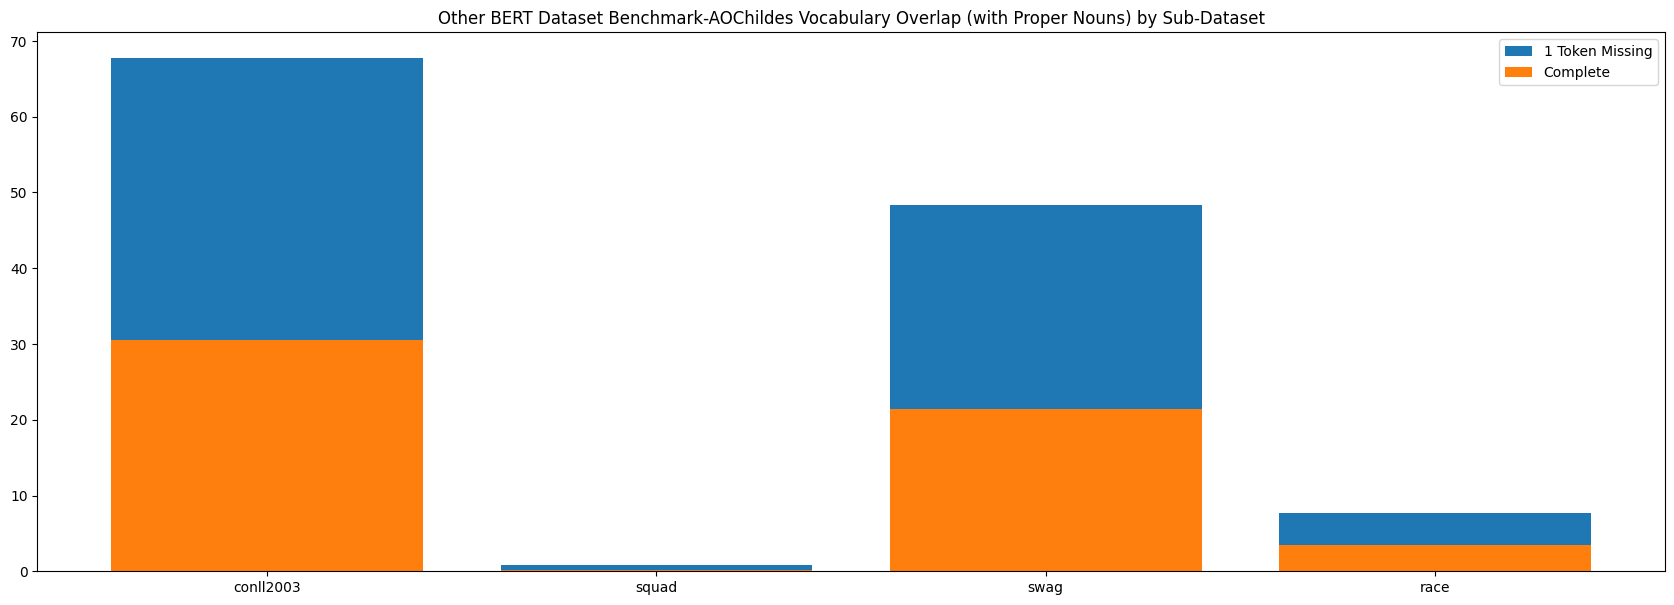

In [50]:
plt.figure(figsize=(21,7))
plt.title("Other BERT Dataset Benchmark-AOChildes Vocabulary Overlap (with Proper Nouns) by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')

plt.legend()
plt.show()

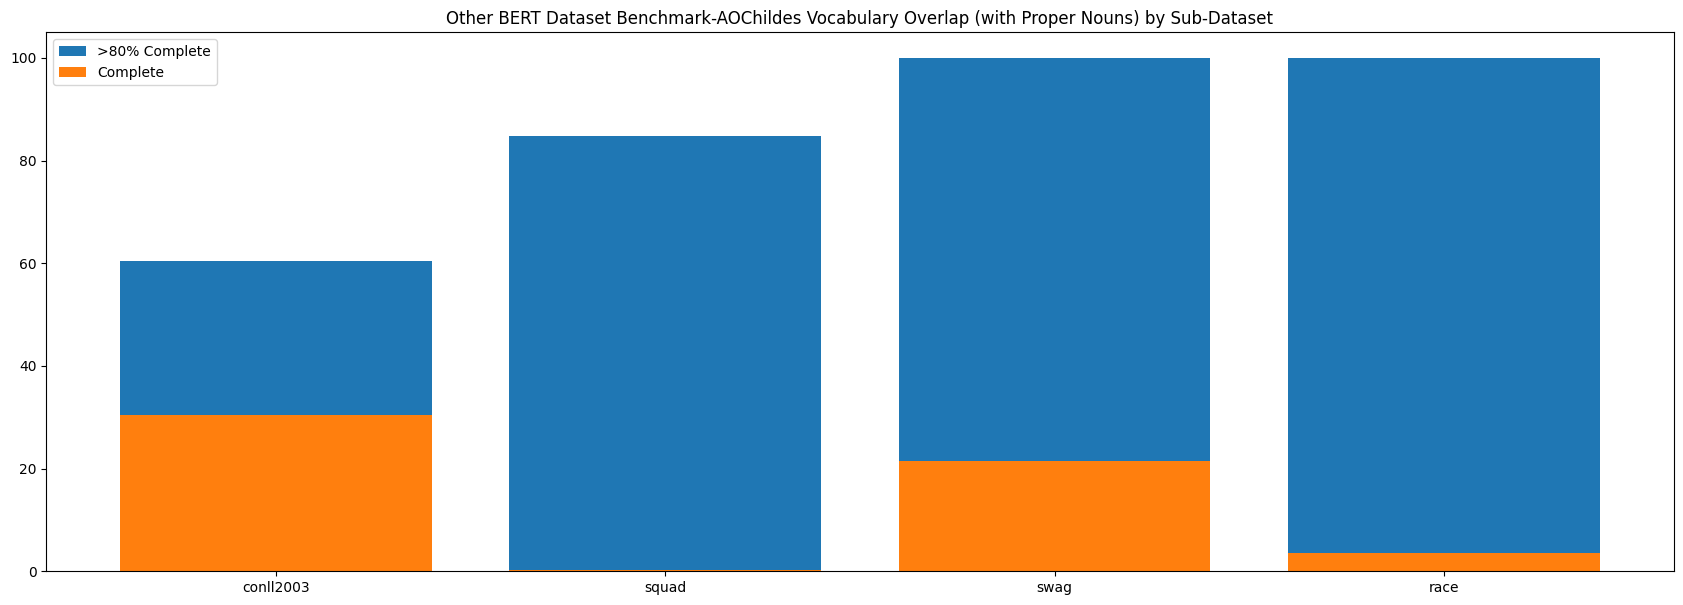

In [51]:
plt.figure(figsize=(21,7))
plt.title("Other BERT Dataset Benchmark-AOChildes Vocabulary Overlap (with Proper Nouns) by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[3] for ds in graph_data],label='>80% Complete')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')

plt.legend()
plt.show()

## GLUE

In [55]:
for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
    new_sentence = sentence.split(' ')
    new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
    print(new_sentence)

['pccw', 's', 'chief', 'operating', 'officer', '', 'mike', 'butcher', '', 'and', 'alex', 'arena', '', 'the', 'chief', 'financial', 'officer', '', 'will', 'report', 'directly', 'to', 'mr', 'so', '']
['the', 'world', 's', 'two', 'largest', 'automakers', 'said', 'their', 'us', 'sales', 'declined', 'more', 'than', 'predicted', 'last', 'month', 'as', 'a', 'late', 'summer', 'sales', 'frenzy', 'caused', 'more', 'of', 'an', 'industry', 'backlash', 'than', 'expected', '']
['according', 'to', 'the', 'federal', 'centers', 'for', 'disease', 'control', 'and', 'prevention', '(', 'news', '-', 'web', 'sites', ')', '', 'there', 'were', '19', 'reported', 'cases', 'of', 'measles', 'in', 'the', 'united', 'states', 'in', '2002', '']
['a', 'tropical', 'storm', 'rapidly', 'developed', 'in', 'the', 'gulf', 'of', 'mexico', 'sunday', 'and', 'was', 'expected', 'to', 'hit', 'somewhere', 'along', 'the', 'texas', 'or', 'louisiana', 'coasts', 'by', 'monday', 'night', '']
['the', 'company', 'didn', 't', 'detail', 'th

['the', '2', '1', '/', '2', '-ton', 'probe', 'will', 'plunge', 'into', 'the', 'thick', 'jovian', 'atmosphere', 'today', 'at', '3', ':', '49', 'pm', 'eastern', 'time', '', 'disintegrating', 'moments', 'later', 'from', 'the', 'friction', 'generated', 'by', 'its', '108000-mph', 'free-fall', '']
['sen', 'michael', 'crapo', '', 'r-idaho', '', 'chairman', 'of', 'the', 'subcommittee', 'that', 'will', 'consider', 'the', 'nomination', '', 'is', 'a', 'longtime', 'friend', '']
['if', 'senator', 'clinton', 'does', 'decide', 'to', 'run', 'in', '2008', '', 'she', 'cannot', 'announce', 'her', 'candidacy', 'before', '2006', '', 'which', 'is', 'when', 'she', 'faces', 're-election', 'for', 'the', 'senate', '']
['people', 'who', 'have', 'opposed', 'these', 'actions', 'throughout', 'are', 'now', 'trying', 'to', 'find', 'fresh', 'reasons', 'to', 'say', 'this', 'wasn', 't', 'the', 'right', 'thing', 'to', 'do', '', '']
['intel', 'sells', 'the', 'current', 'top', 'pentium', 'for', 'us', '', '637', 'in', 'quan

In [7]:
mrpc = load_dataset('glue','mrpc')

Found cached dataset glue (/Users/user/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
sys.path.append(os.path.abspath(os.path.join('..', 'data')))
contractions = set(['nt','s','re','t','d','ll'])

def filter_ds(example, additional_exclusions=True):
    sentence = example['sentence']
    new_sentence = sentence.split(' ')
            
    if additional_exclusions:
        new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
    new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
    new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
    
    for word in new_sentence:
        if word not in vocab_set:
            return False
    
    return True

In [10]:
mrpc['train'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [13]:
example = mrpc['train']
t1 = list(example.features)[0]
t2 = list(example.features)[1]
sentences = [' '.join(i) for i in zip(example[t1], example[t2])]

In [14]:
sentences

['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence . Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion . Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .",
 "They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added . On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .",
 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 . Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .',
 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange . PG & E Corp. shares jumped $ 1.63 or 8 pe

In [28]:
cola.filter(filter_ds)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 5259
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 653
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 681
    })
})

## SuperGLUE filtering

In [39]:
ds = load_dataset('super_glue','record')

Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/record/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
ds['train'][1]

{'passage': "Caracas, Venezuela (CNN) -- It's been more than 180 years since Venezuelans saw Simon Bolivar's face. But the revolutionary leader's thick sideburns, bushy eyebrows and steely gaze popped out from behind picture frames Tuesday in new 3-D images unveiled by President Hugo Chavez. Researchers used several software programs to reconstruct the face of the man who liberated Bolivia, Colombia, Ecuador, Panama, Peru and Venezuela from the Spanish crown. Scans of Bolivar's skeletal remains, which investigators exhumed two years ago, factored into their calculations. So did historical paintings, photos of restored uniforms Bolivar wore and images of middle-aged Venezuelans, officials said.\n@highlight\nResearchers use computer programs to reconstruct Simon Bolivar's face\n@highlight\nVenezuelan President Hugo Chavez unveils new, 3-D portraits of Bolivar\n@highlight\nResearchers use data from skeletal remains exhumed two years ago\n@highlight\nAn investigation into Bolivar's 1830 de

In [53]:
subsets = ['boolq', 'cb', 'copa', 'multirc', 'record', 'rte', 'wic', 'wsc', 'wsc.fixed', 'axb', 'axg']
# subsets = ['cola']
graph_data = []
inclusivity_check = []
for subset in subsets:
    dataset = load_dataset('super_glue',subset)
    print(dataset)
    
    inclusivity_check_ds = []
    
    for segment in dataset.keys():
        print(segment)
        if subset == 'wsc' or subset == 'wsc.fixed':
            sentences = dataset[segment]['text']
        elif subset == 'record':
            sentences = dataset[segment]['passage']
        elif 'sentence' in dataset[segment].features:
            sentences = dataset[segment]['sentence']
        
        else:
            t1 = list(dataset[segment].features)[0]
            t2 = list(dataset[segment].features)[1]
            sentences = [' '.join(i) for i in zip(dataset[segment][t1], dataset[segment][t2])]
        denom = len(sentences)

        for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
            new_sentence = sentence.split(' ')
            #removing proper nouns helps with MRPC
            contractions = set(['nt','s','re','t','d','ll'])
            new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
            new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
            new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
            sentence_inclusion = []
            for word in new_sentence:
                if word not in vocab_set:
                    inclusive_word = 0
                else:
                    inclusive_word = 1
                sentence_inclusion.append(inclusive_word)
            inclusivity_check_ds.append(sentence_inclusion)
            inclusivity_check.append([subset, sentence_inclusion])
    
    complete_sentences = 0
    missing_1 = 0
    most_included = 0
    n_ex = len(inclusivity_check_ds)
    for sentence in inclusivity_check_ds:
        if len(sentence) == sum(sentence):
            complete_sentences +=1
        if len(sentence) == sum(sentence)+1:
            missing_1 +=1
        if len(sentence) <= sum(sentence)*1.25:
            most_included +=1
    print(subset)
    complete_sentences_c = complete_sentences/n_ex
    print(complete_sentences_c)
    missing_1_c = (complete_sentences+missing_1)/n_ex
    print(missing_1_c)
    most_included_c = most_included/n_ex
    graph_data.append([subset,complete_sentences_c,missing_1_c,most_included_c])

                #if it's a new word, add it, print the new words


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/boolq/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})
train
validation
test
boolq
0.006335466064483754
0.0312382386149793


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/cb/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 250
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 56
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 250
    })
})
train
validation
test
cb
0.13129496402877697
0.31115107913669066


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/copa/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label'],
        num_rows: 100
    })
    test: Dataset({
        features: ['premise', 'choice1', 'choice2', 'question', 'idx', 'label'],
        num_rows: 500
    })
})
train
validation
test
copa
0.508
0.831


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/multirc/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 27243
    })
    validation: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 4848
    })
    test: Dataset({
        features: ['paragraph', 'question', 'answer', 'idx', 'label'],
        num_rows: 9693
    })
})
train
validation
test
multirc
0.016489565383878996
0.05322611525942945


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/record/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['passage', 'query', 'entities', 'entity_spans', 'answers', 'idx'],
        num_rows: 100730
    })
    validation: Dataset({
        features: ['passage', 'query', 'entities', 'entity_spans', 'answers', 'idx'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['passage', 'query', 'entities', 'entity_spans', 'answers', 'idx'],
        num_rows: 10000
    })
})
train
validation
test
record
4.141472707694856e-05
0.0006709185786465667


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/rte/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 277
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 3000
    })
})
train
validation
test
rte
0.06346453962198717
0.17773539101786023


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/wic/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 5428
    })
    validation: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 638
    })
    test: Dataset({
        features: ['word', 'sentence1', 'sentence2', 'start1', 'start2', 'end1', 'end2', 'idx', 'label'],
        num_rows: 1400
    })
})
train
validation
test
wic
0.67023841414412
0.850656308598982


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/wsc/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 554
    })
    validation: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 146
    })
})
train
validation
test
wsc
0.4079601990049751
0.7201492537313433


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/wsc.fixed/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 554
    })
    validation: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 104
    })
    test: Dataset({
        features: ['text', 'span1_index', 'span2_index', 'span1_text', 'span2_text', 'idx', 'label'],
        num_rows: 146
    })
})
train
validation
test
wsc.fixed
0.4079601990049751
0.7201492537313433


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/axb/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['sentence1', 'sentence2', 'idx', 'label'],
        num_rows: 1104
    })
})
test
axb
0.24456521739130435
0.36141304347826086


Found cached dataset super_glue (/Users/user/.cache/huggingface/datasets/super_glue/axg/1.0.3/bb9675f958ebfee0d5d6dc5476fafe38c79123727a7258d515c450873dbdbbed)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'idx', 'label'],
        num_rows: 356
    })
})
test
axg
0.2247191011235955
0.4438202247191011


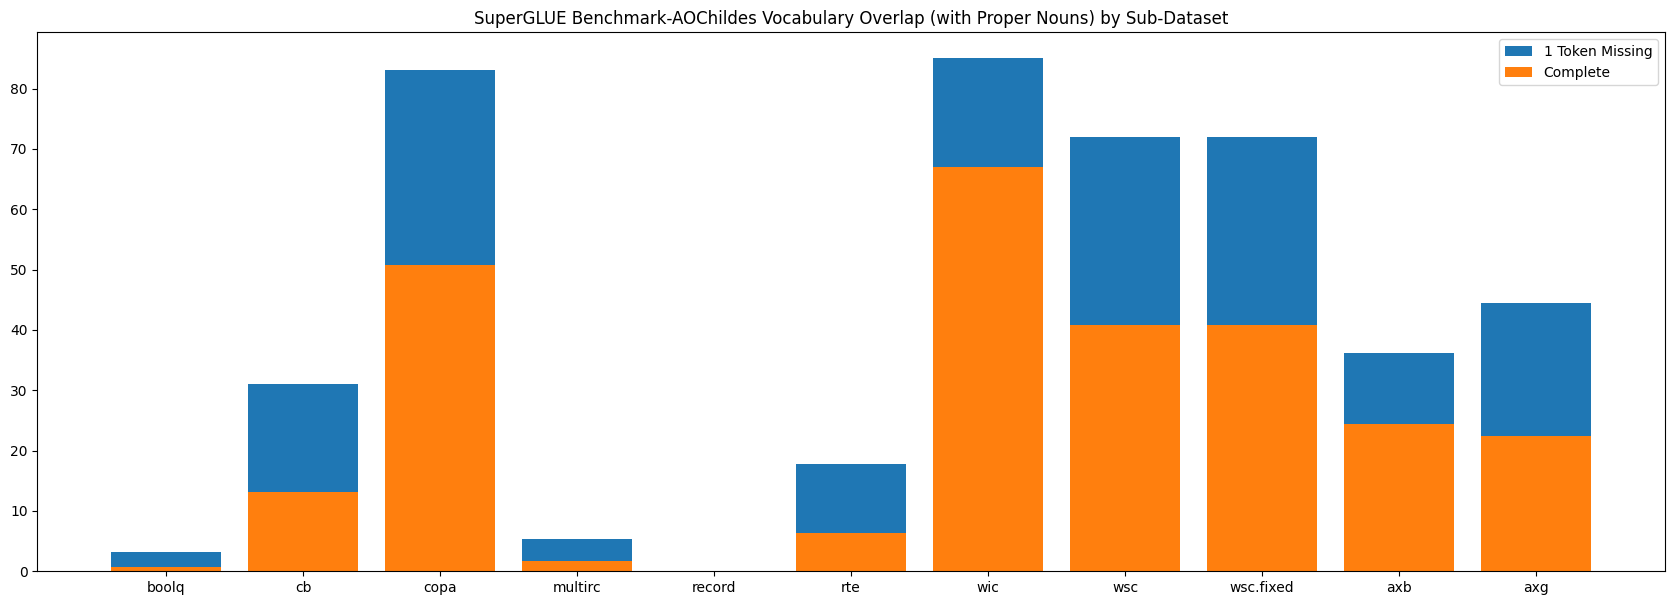

In [43]:
plt.figure(figsize=(21,7))
plt.title("SuperGLUE Benchmark-AOChildes Vocabulary Overlap (with Proper Nouns) by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')

plt.legend()
plt.show()

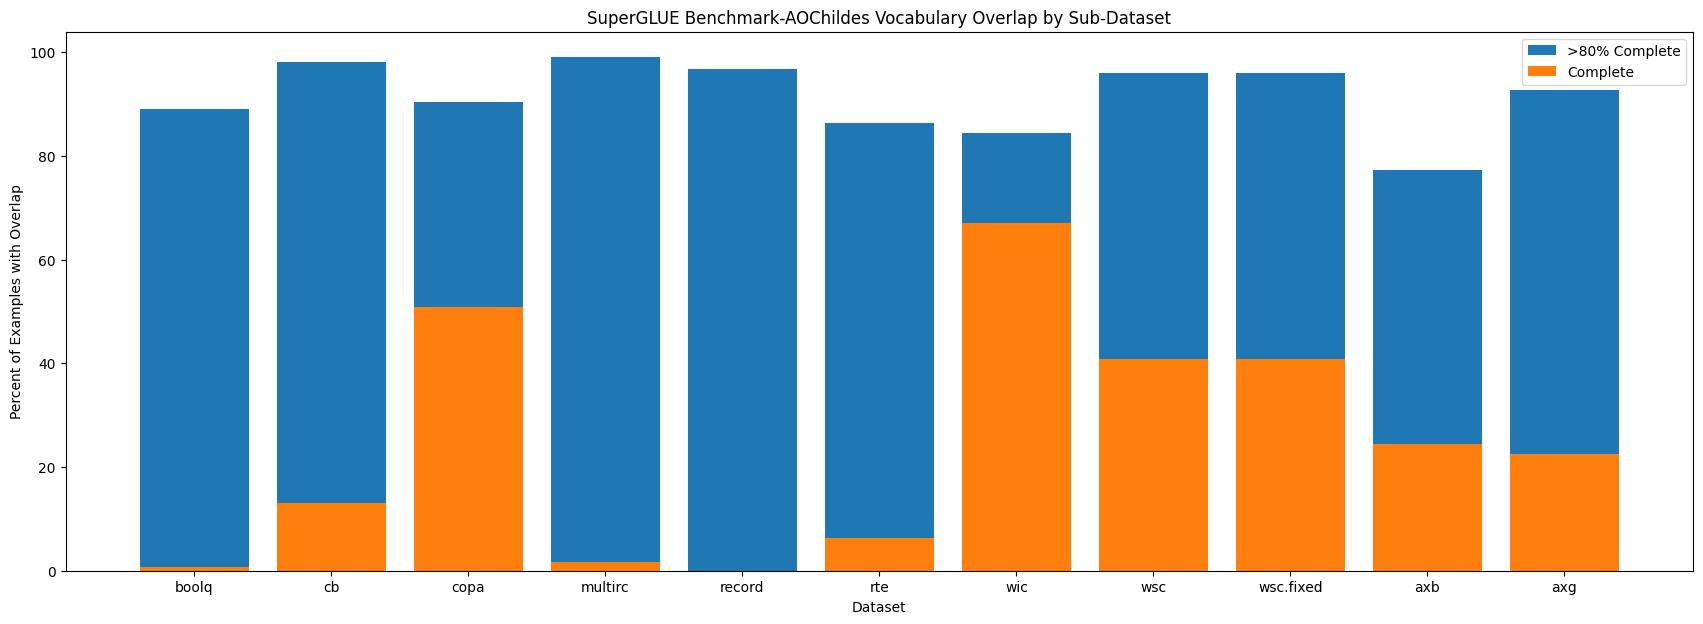

In [54]:
plt.figure(figsize=(21,7))
plt.title("SuperGLUE Benchmark-AOChildes Vocabulary Overlap by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[3] for ds in graph_data],label='>80% Complete')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')
plt.xlabel('Dataset')
plt.ylabel('Percent of Examples with Overlap')

plt.legend()
plt.show()

## GLUE filtering

In [130]:
subsets = ['cola', 'sst2', 'mrpc', 'qqp', 'stsb', 'mnli', 'mnli_mismatched', 'mnli_matched', 'qnli', 'rte', 'wnli', 'ax']
# subsets = ['cola']
graph_data = []
inclusivity_check = []
for subset in subsets:
    dataset = load_dataset('glue',subset)
    print(dataset)
    
    inclusivity_check_ds = []
    
    for segment in dataset.keys():
        print(segment)
        if 'sentence' in dataset[segment].features:
            sentences = dataset[segment]['sentence']
        
        else:
            t1 = list(dataset[segment].features)[0]
            t2 = list(dataset[segment].features)[1]
            sentences = [' '.join(i) for i in zip(dataset[segment][t1], dataset[segment][t2])]
        denom = len(sentences)

        for n,sentence in enumerate(sentences):
#             if n%100 == 0:
#                 print(time.ctime())
#                 print(f"{round(100*n/float(denom),2)}% Complete")
            new_sentence = sentence.split(' ')
            #removing proper nouns helps with MRPC
            contractions = set(['nt','s','re','t','d','ll'])
            new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
            new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
            new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
            sentence_inclusion = []
            for word in new_sentence:
                if word not in vocab_set:
                    inclusive_word = 0
                else:
                    inclusive_word = 1
                sentence_inclusion.append(inclusive_word)
            inclusivity_check_ds.append(sentence_inclusion)
            inclusivity_check.append([subset, sentence_inclusion])
    
    complete_sentences = 0
    missing_1 = 0
    most_included = 0
    n_ex = len(inclusivity_check_ds)
    for sentence in inclusivity_check_ds:
        if len(sentence) == sum(sentence):
            complete_sentences +=1
        if len(sentence) == sum(sentence)+1:
            missing_1 +=1
        if len(sentence) <= sum(sentence)*1.25:
            most_included +=1
    print(subset)
    complete_sentences_c = complete_sentences/n_ex
    print(complete_sentences_c)
    missing_1_c = (complete_sentences+missing_1)/n_ex
    print(missing_1_c)
    most_included_c = most_included/n_ex
    graph_data.append([subset,complete_sentences_c,missing_1_c,most_included_c])

                #if it's a new word, add it, print the new words


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\cola\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 8551
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1043
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1063
    })
})
train
validation
test
cola
0.6186544055550343
0.9234306089893967


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})
train
validation
test
sst2
0.3123411667285343
0.632106450415465


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})
train
validation
test
mrpc
0.10170660230994656
0.22099637993449406


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\qqp\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})
train
validation
test
qqp
0.32749820494667653
0.5391837191492893


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\stsb\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})
train
validation
test
stsb
0.40148354195642094
0.5921418636995828


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
train
validation_matched
validation_mismatched
test_matched
test_mismatched
mnli
0.24817126243078574
0.43796644382303374


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli_mismatched\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})
validation
test
mnli_mismatched
0.25387468875450986
0.41877127902840594


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mnli_matched\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
})
validation
test
mnli_matched
0.2525113456733466
0.444750395186375


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\qnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})
train
validation
test
qnli
0.09316238577319766
0.27335759797352793


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\rte\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})
train
validation
test
rte
0.06346453962198717
0.17773539101786023


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\wnli\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 635
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 71
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 146
    })
})
train
validation
test
wnli
0.41784037558685444
0.653755868544601


Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\ax\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 1104
    })
})
test
ax
0.24456521739130435
0.36141304347826086


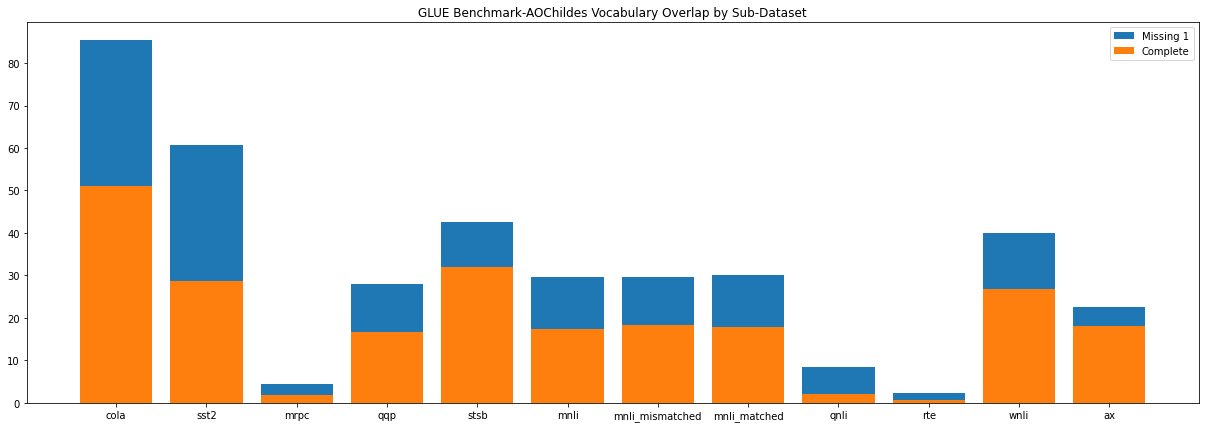

In [100]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap (with Proper Nouns) by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')

plt.legend()
plt.show()

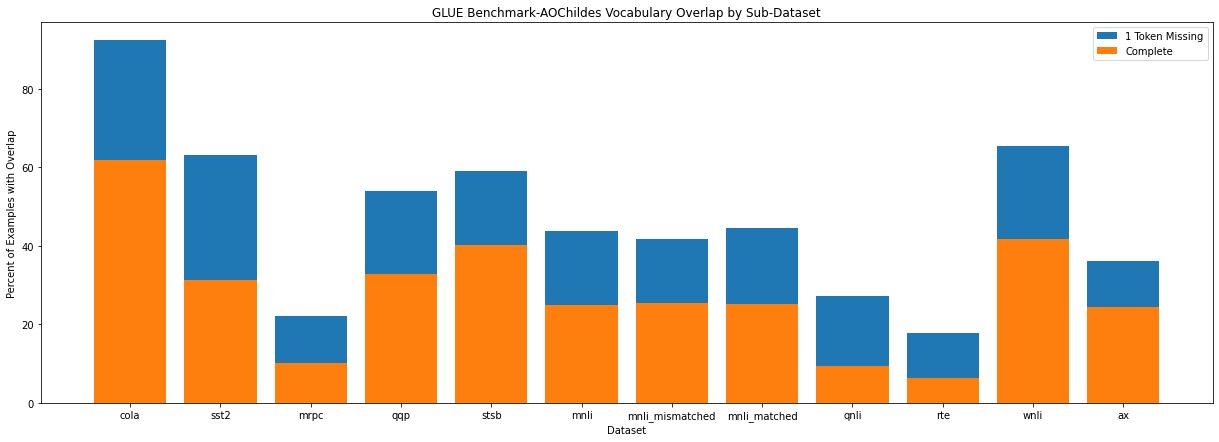

In [126]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[2] for ds in graph_data],label='1 Token Missing')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')
plt.xlabel('Dataset')
plt.ylabel('Percent of Examples with Overlap')

plt.legend()
plt.show()

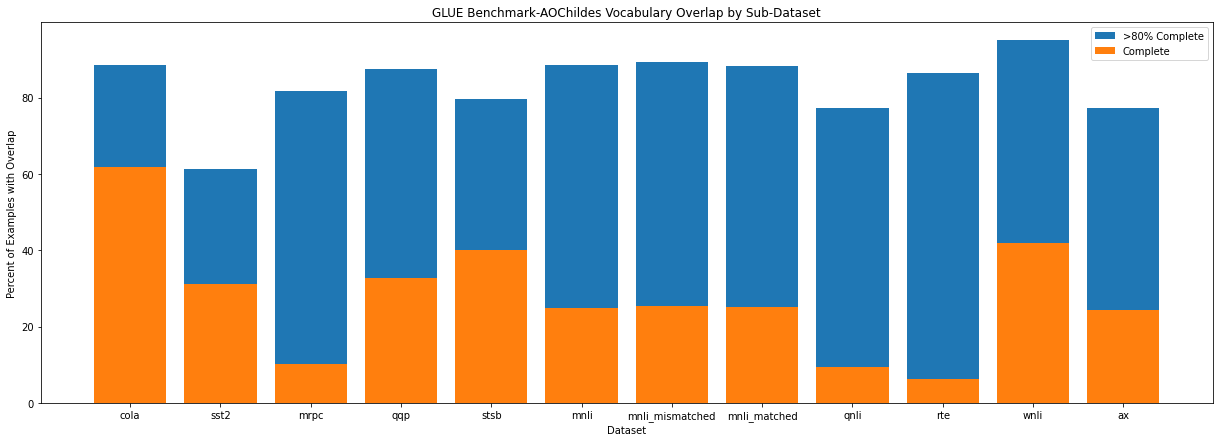

In [131]:
plt.figure(figsize=(21,7))
plt.title("GLUE Benchmark-AOChildes Vocabulary Overlap by Sub-Dataset")
plt.bar([ds[0] for ds in graph_data],[100*ds[3] for ds in graph_data],label='>80% Complete')
plt.bar([ds[0] for ds in graph_data],[100*ds[1] for ds in graph_data],label='Complete')
plt.xlabel('Dataset')
plt.ylabel('Percent of Examples with Overlap')

plt.legend()
plt.show()

In [129]:
for sentence in inclusivity_check:
    if sentence[0] == 'mrpc':
        print(sentence)

['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]]
['mrpc', 

['mrpc', [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,

['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1]]
['mrpc', [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]]
['mrpc', [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 

['mrpc', [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

['mrpc', [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]]
['mrpc', [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
['mrpc', [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [127]:
#why is MRPC coverage so low?
mrpc = load_dataset('glue','mrpc')
sentences = mrpc['train']['sentence1']
contractions = set(['nt','s','re','t','d','ll'])
for n,sentence in enumerate(sentences):
    new_sentence = sentence.split(' ')
    new_sentence = [w for n,w in enumerate(new_sentence) if (w == w.lower() or n==0)]
    new_sentence = [re.sub('[0-9!:&“”—\-_,@#$?;’.\'\(\)"]', '', w.lower()) for w in new_sentence]
    new_sentence = [w for w in new_sentence if w != '' and w not in contractions]
    print(new_sentence)

Reusing dataset glue (C:\Users\dpechi\.cache\huggingface\datasets\glue\mrpc\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

['amrozi', 'accused', 'his', 'brother', 'whom', 'he', 'called', 'the', 'witness', 'of', 'deliberately', 'distorting', 'his', 'evidence']
['yucaipa', 'owned', 'before', 'selling', 'the', 'chain', 'to', 'in', 'for', 'billion']
['they', 'had', 'published', 'an', 'advertisement', 'on', 'the', 'on', 'offering', 'the', 'cargo', 'for', 'sale', 'he', 'added']
['around', 'shares', 'were', 'up', 'cents', 'or', '%', 'at', 'having', 'earlier', 'set', 'a', 'record', 'high', 'of']
['the', 'stock', 'rose', 'or', 'about', 'percent', 'to', 'close', 'at', 'on', 'the']
['revenue', 'in', 'the', 'first', 'quarter', 'of', 'the', 'year', 'dropped', 'percent', 'from', 'the', 'same', 'period', 'a', 'year', 'earlier']
['the', 'had', 'a', 'weekly', 'gain', 'of', 'or', 'percent', 'closing', 'at', 'on']
['the', 'then', 'appealed', 'to', 'the', 'state']
['that', 'compared', 'with', 'million', 'or', 'cents', 'per', 'share', 'in', 'the', 'yearago', 'period']
['shares', 'of', 'a', 'much', 'larger', 'company', 'with', 

['mr', 'had', 'been', 'living', 'in', 'a', 'protective', 'custody', 'unit', 'since', 'being', 'transferred', 'to', 'the', 'prison', 'on']
['winfs', 'will', 'require', 'that', 'applications', 'be', 'rewritten', 'to', 'exploit', 'such', 'capabilities']
['the', 'pilot', 'decided', 'to', 'fly', 'to', 'which', 'has', 'longer', 'runways', 'than']
['the', 'number', 'of', 'probable', 'cases', 'dropped', 'to', 'on', 'from', 'on', 'in', 'and', 'around', 'a', 'city', 'of', 'four', 'million', 'people']
['despite', 'their', 'differences', 'and', 'leaders', 'said', 'there', 'were', 'areas', 'of', 'agreement']
['bolland', 'told', 'the', 'of', 'the', 'was', 'astonished', 'at', 'question']
['symbol', 'former', 'chief', 'accounting', 'officer', 'is', 'expected', 'to', 'plead', 'guilty', 'in', 'a', 'federal', 'court', 'in', 'later', 'according', 'to', 'reports']
['two', 'partners', 'in', 'business', 'were', 'arrested', 'last', 'week', 'and', 'questioned', 'by', 'magistrates', 'investigating', 'the', 'col

['the', 'said', 'there', 'was', 'a', 'clear', 'risk', 'of', 'terrorist', 'attack', 'in', 'and']
['the', 'fell', 'or', 'about', 'percent', 'to']
['the', 'truck', 'carried', 'the', 'equivalent', 'of', 'tons', 'of', 'emergency', 'ministry', 'official', 'said']
['an', 'international', 'warrant', 'for', 'his', 'arrest', 'was', 'issued', 'both', 'to', 'the', 'authorities', 'and', 'to']
['peoplesoft', 'board', 'of', 'directors', 'on', 'unanimously', 'rejected', 'revised', 'bid', 'of', 'per', 'share']
['luzerne', 'told', 'a', 'news', 'conference', 'that', 'authorities', 'were', '``continuing', 'to', 'make', 'significant', 'progress', 'in', 'the', 'case']
['berry', 'also', 'married', 'and', 'divorced', 'his', 'second', 'wife', 'twice', 'most', 'recently', 'in']
['goldman', 'also', 'raised', 'its', 'quarterly', 'dividend', 'to', 'cents', 'from', 'cents', 'citing', 'the', 'new', 'tax', 'law']
['tomorrow', 'testimony', 'is', 'to', 'give', 'an', 'inside', 'look', 'at', 'tax', 'shelter', 'developmen

In [6]:
import time
vocab_dict = {}
bad_words = []
for segment in ['train','validation','test']:
    print(segment)
    sentences = dataset[segment]['sentence']
    denom = len(sentences)
    
    for n,sentence in enumerate(sentences):
        if n%100 == 0:
            print(time.ctime())
            print(f"{round(100*n/float(denom),2)}% Complete")
        new_sentence = sentence.split(' ')
        new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
        for word in new_sentence:
            #if it's a new word, add it, print the new words
            if word not in vocab_dict and word in words.words():

                vocab_dict[word] = 1
            
            else:
                if word not in words.words():
                    if word not in bad_words:
                        bad_words.append(word)
                else:
                    vocab_dict[word] += 1


train
Thu Oct 20 22:51:48 2022
0.0% Complete
Thu Oct 20 22:53:17 2022
1.17% Complete
Thu Oct 20 22:55:59 2022
2.34% Complete
Thu Oct 20 22:58:48 2022
3.51% Complete
Thu Oct 20 23:00:24 2022
4.68% Complete
Thu Oct 20 23:01:57 2022
5.85% Complete
Thu Oct 20 23:03:19 2022
7.02% Complete
Thu Oct 20 23:04:51 2022
8.19% Complete
Thu Oct 20 23:06:12 2022
9.36% Complete
Thu Oct 20 23:08:03 2022
10.53% Complete
Thu Oct 20 23:09:54 2022
11.69% Complete
Thu Oct 20 23:11:35 2022
12.86% Complete
Thu Oct 20 23:13:29 2022
14.03% Complete
Thu Oct 20 23:15:30 2022
15.2% Complete
Thu Oct 20 23:17:50 2022
16.37% Complete
Thu Oct 20 23:20:02 2022
17.54% Complete
Thu Oct 20 23:22:01 2022
18.71% Complete
Thu Oct 20 23:24:03 2022
19.88% Complete
Thu Oct 20 23:26:54 2022
21.05% Complete
Thu Oct 20 23:28:48 2022
22.22% Complete
Thu Oct 20 23:30:41 2022
23.39% Complete
Thu Oct 20 23:32:15 2022
24.56% Complete
Thu Oct 20 23:34:51 2022
25.73% Complete
Thu Oct 20 23:37:41 2022
26.9% Complete
Thu Oct 20 23:40:46 20

In [39]:
import time
inclusivity_check = []
vocab_set = set(vocab_freq['word'])
for segment in ['train','validation','test']:
    print(segment)
    sentences = dataset[segment]['sentence']
    denom = len(sentences)
    
    for n,sentence in enumerate(sentences):
        if n%100 == 0:
            print(time.ctime())
            print(f"{round(100*n/float(denom),2)}% Complete")
        new_sentence = sentence.split(' ')
        new_sentence = [re.sub('[!,@#$?;.\'"]', '', w.lower()) for w in new_sentence]
        
        sentence_inclusion = []
        for word in new_sentence:
            if word not in vocab_set:
                inclusive_word = 0
            else:
                inclusive_word = 1
            sentence_inclusion.append(inclusive_word)
        inclusivity_check.append(sentence_inclusion)
            
            
            #if it's a new word, add it, print the new words
            

train
Fri Oct 21 11:39:50 2022
0.0% Complete
Fri Oct 21 11:39:50 2022
1.17% Complete
Fri Oct 21 11:39:50 2022
2.34% Complete
Fri Oct 21 11:39:50 2022
3.51% Complete
Fri Oct 21 11:39:50 2022
4.68% Complete
Fri Oct 21 11:39:50 2022
5.85% Complete
Fri Oct 21 11:39:50 2022
7.02% Complete
Fri Oct 21 11:39:50 2022
8.19% Complete
Fri Oct 21 11:39:50 2022
9.36% Complete
Fri Oct 21 11:39:50 2022
10.53% Complete
Fri Oct 21 11:39:51 2022
11.69% Complete
Fri Oct 21 11:39:51 2022
12.86% Complete
Fri Oct 21 11:39:51 2022
14.03% Complete
Fri Oct 21 11:39:51 2022
15.2% Complete
Fri Oct 21 11:39:51 2022
16.37% Complete
Fri Oct 21 11:39:51 2022
17.54% Complete
Fri Oct 21 11:39:51 2022
18.71% Complete
Fri Oct 21 11:39:51 2022
19.88% Complete
Fri Oct 21 11:39:51 2022
21.05% Complete
Fri Oct 21 11:39:51 2022
22.22% Complete
Fri Oct 21 11:39:51 2022
23.39% Complete
Fri Oct 21 11:39:51 2022
24.56% Complete
Fri Oct 21 11:39:51 2022
25.73% Complete
Fri Oct 21 11:39:51 2022
26.9% Complete
Fri Oct 21 11:39:51 20

In [44]:
complete_sentences = 0
missing_1 = 0
for sentence in inclusivity_check:
    if len(sentence) == sum(sentence):
        complete_sentences +=1
    if len(sentence) == sum(sentence)+1:
        missing_1 +=1
print(complete_sentences/len(inclusivity_check))
print((complete_sentences+missing_1)/len(inclusivity_check))

0.5050201745331707
0.8470488880547996


In [ ]:
# Compute percentage of examples that only contain words in our vocabulary

In [32]:
bad_words_df = pd.DataFrame(bad_words)

In [38]:
vocab_freq[vocab_freq['word']=='mom']

,Unnamed: 0,word,frequency


In [36]:
n=0
vocab_set = set(vocab_freq['word'])
for w in bad_words:
    if w not in vocab_set:
        print(w)
        n+=1

murkier
herman
critics
5
sd
sf
john
waltzes
urinated
vanished
ron
aliza
ok
poorer
geniuses
inclined
susan
janet
became
succumbed
lobbyists
succumbs
youll
couldnt
louise
isnt
survived
hasnt
paid
marianne
``

heard
lynn
kathy
elected
children
mickey
women
gary
criticizes
subjects
emitted
ions
contained
resulted
grades
occupies
inhabits
straddles
straddled
avoided
agents
concluded
fond
wimp
regards
politicians
harriet
vivien
virginia
manuscripts
succeeded
flo
miami
play-offs
french
recited
fools
proud
resembles
resembled
10
lb
max
impresses
proclaimed
authorities
criticized
alleged
wagered
enemys
josé
caspar
lilly
recounted
reviewed
josés
questioned
betsy
wildwood
patrons
oscar
hadnt
dulles
angleton
truman
babel
meryl
harris
lesbians
gays
governments
david
gorbachev
rome
carthage
romes
europe
1492
mercury
tourists
guinevere
filed
attended
seminars
physicists
lucie
revised
dld
prescribes
tom
india
attributed
dismissed
dartmouth
60
utah
prisoners
divulged
friday
saturday
awful:
phineas
maxi

In [22]:
n=0
vocab_set = set(vocab_freq['word'])
for w in vocab_dict:
    if w not in vocab_set:
        print(w)
        n+=1

pub
stupor
vanishing
thereby
zigzagged
correspondingly
obnoxious
worded
succumb
corruption
corrupt
corporate
headquarters
suspected
weatherman
astronomy
meteorology
inadequate
unlikely
probable
murderer
uneducated
undisciplined
attentive
diligent
linguist
strived
improve
electrode
circuit
terrorist
parcel
litigation
petrol
widow
donated
valuable
intimately
pompous
conclusively
threadbare
doubtful
abroad
desired
detest
refusing
horrific
refusal
bartender
neuroses
spouse
dickens
barcelona
harassment
autonomous
dogged
infidelity
informal
perception
oneself
moral
impeccable
readable
philosopher
producer
inherit
seminar
godsend
garish
biography
lettering
acquainted
dill
proposal
costly
defendant
stoutly
rutherford
squander
recursive
semantics
generative
preposterous
myron
lute
hefty
whisky
fiat
yearn
luscious
executed
reheat
peruse
deed
forgery
invariably
funds
employee
employer
geezer
carelessly
objection
simultaneously
honorable
polynomial
lemma
politics
blackjack
dislike
true
mao
catastr

In [28]:
print(f"Percent Missing: {100*round(n/len(vocab_dict.keys()),4)}%")
#561 of 3731

Percent Missing: 15.09%


In [32]:
import random

rnd = ['Maggie','Lisa','Tyler','Dan','Matthew','Will','Surendra','Paulina','Nick','Miles']
exceptions = ['Matthew']

rnd_filt = [cool_person for cool_person in rnd if cool_person not in exceptions]
random.shuffle(rnd_filt)
rnd_filt
for cool_person in rnd_filt[:5]:
    print(f"@{cool_person}")

@Lisa
@Dan
@Paulina
@Tyler
@Maggie
